In [42]:
# import libraries

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# cleaning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# exploration
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import levene, ttest_ind

# modeling
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score

# 1.1 Data Cleaning: Load Data

In [2]:
# load spam.csv into dataframe
spam = pd.read_csv("spam.csv", encoding="latin-1")
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop empty columns and rename v1 and v2
spam["target"] = spam.v1
spam["text"] = spam.v2

for col in spam.columns:
    if (col != "target") & (col != "text"):
        spam.drop(col, axis=1, inplace=True)
        
spam.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 1.2 See if classes are balanced

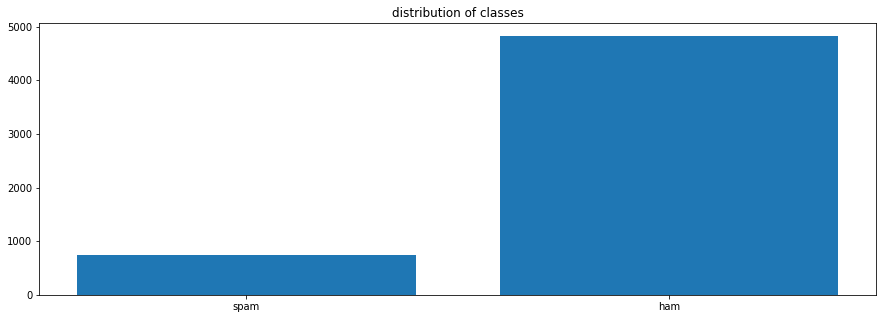

In [4]:
# get value counts
value_counts = dict(spam.target.value_counts())

# plot class distribution
plt.figure(figsize=(15, 5))
plt.bar(["spam", "ham"], [value_counts["spam"], value_counts["ham"]])
plt.title("distribution of classes")
plt.show()

Most of the data is ham. So I will use a stratified split

# 1.3 Train / Test Split

In [8]:
# stratified split
sss = StratifiedShuffleSplit(test_size = 0.2, random_state=42)
train_index, test_index = next(sss.split(spam.text, spam.target))

len(train_index), len(test_index)

(4457, 1115)

In [9]:
# use indices to split the data
train = spam.iloc[train_index]
test = spam.iloc[test_index]

In [10]:
# check value counts to ensure a quality split
print(train.target.value_counts(normalize=True))
print(test.target.value_counts(normalize=True))

ham     0.865829
spam    0.134171
Name: target, dtype: float64
ham     0.866368
spam    0.133632
Name: target, dtype: float64


# 1.4 Check for duplicate values

From this point on I am only inspecting the training set. However I will apply changes to both sets as needed. 

In [11]:
train.duplicated().sum()

265

In [12]:
# drop duplicates from both train and test sets

train = train.drop_duplicates()
test = test.drop_duplicates()

# 2.1 Exploratory Data Analysis: Checking Top Words

Now I will which words have the highest count value in spam and ham messages. 

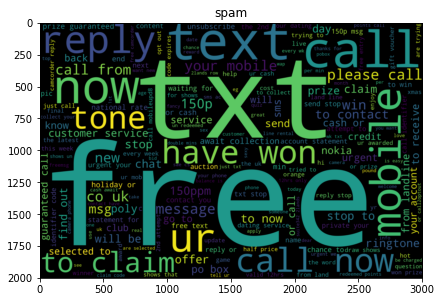

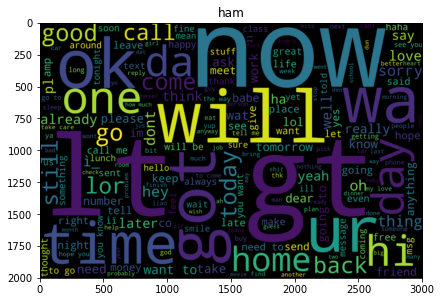

In [13]:
# seperate ham from spam
spam = train[train.target == "spam"].text
ham = train[train.target == "ham"].text

# function for wordclouds
def to_wordcloud(articles, title):
    
    string_of_words = " ".join(articles)
    string_of_words = string_of_words.lower()
    
    wc = WordCloud(width = 3000, height = 2000)
    
    plt.imshow(wc.generate(string_of_words), interpolation="bilinear")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()
    
    
# word clouds   
to_wordcloud(spam, "spam")

print("\n\n\n")

to_wordcloud(ham, "ham")

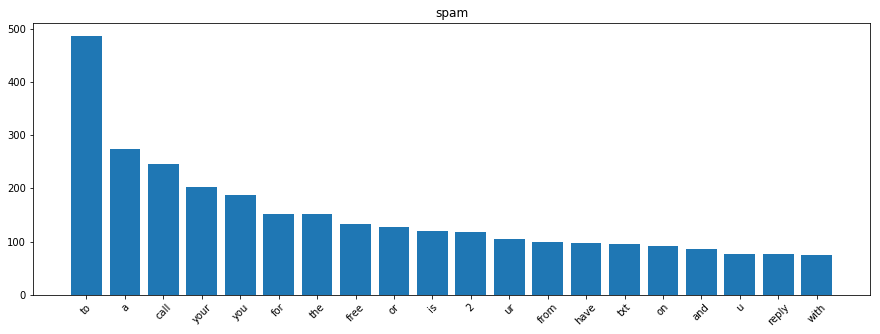

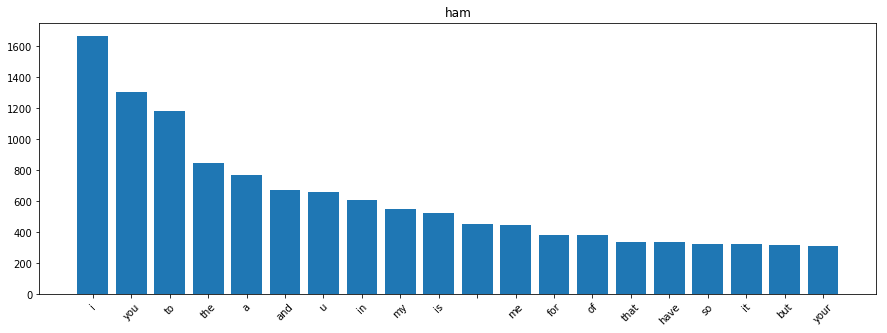

In [14]:
# function for bar graphs
def plot_word_count(articles, title):
    
    string_of_words = " ".join(articles)
    string_of_words = string_of_words.lower()
    collection = string_of_words.split(" ")
    
    cnt = Counter(collection)
    words = [i[0] for i in cnt.most_common(20)]
    counts = [i[1] for i in cnt.most_common(20)]
    
    plt.figure(figsize=(15, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
# bar grapgs
plot_word_count(spam, "spam")

print("\n\n\n")

plot_word_count(ham, "ham")

We can see that the words "you" and "call" are high in both. Spam has more of the words "txt" and "reply". Ham is distinguished by the word "I".

# 2.2 Explore length as a factor.

Now I will create a new feature "len" that measures the length of the message. I will check to see how the length of the message correlates with the class (spam or ham). Also, I will now one-hot-encode the target variable.

In [21]:
# one hot encode target

#train
ohe_target_train = train.target.map(lambda x: 1 if x=="spam" else 0)
train.drop("target", axis=1, inplace=True)
train["target"] = ohe_target_train

#test
ohe_target_test = test.target.map(lambda x: 1 if x=="spam" else 0)
test.drop("target", axis=1, inplace=True)
test["target"] = ohe_target_test

In [22]:
# create "len" feature
train["len"] = train["text"].map(len)
train.head()

,text,target,len
184,Going on nothing great.bye,0,26
2171,I wont. So wat's wit the guys,0,29
5422,Ok k..sry i knw 2 siva..tats y i askd..,0,39
4113,Where are you ? What do you do ? How can you s...,0,154
4588,Have you not finished work yet or something?,0,44


In [23]:
# test correlation
train.corr()

,target,len
target,1.0000,0.3824
len,0.3824,1.0000


The correlation isn't too high. I will now use a t-test to see if there is a statistcally significant difference in length between spam and ham messages. To decide which t-test to use I will use a levene test to examine the difference in variances. For the levene test the null hypothesis will be that the variances are the same, and the alternative hypothesis will be that they are different. The alpha value will be 0.05

In [26]:
# leven test
levene(train.target, train["len"])

LeveneResult(statistic=3780.649897608388, pvalue=0.0)

The p-value is below 0.05 so we can reject the null hypothesis and assume the variances are significantly different. So now I will use a welch's t-test. The null hypothesis will be that the length of the message does not vary significantly between spam and ham messages. The alternative hypothesis will be that the length of the message varies significantly between spam and ham messages. The alpha value will be 0.05

In [27]:
ttest_ind(train[train.target == 1]["len"], train[train.target == 0]["len"], equal_var=False)

Ttest_indResult(statistic=42.27182480244643, pvalue=4.1600411376224655e-241)

The p-value is above 0.05, so we can say there is no significant difference between the lengths of spam and ham messages. This means that I should not use length as a feature in my model. I will now remove the "len" column

In [28]:
# drop len column
train.drop("len", axis=1, inplace=True)
train.head()

,text,target
184,Going on nothing great.bye,0
2171,I wont. So wat's wit the guys,0
5422,Ok k..sry i knw 2 siva..tats y i askd..,0
4113,Where are you ? What do you do ? How can you s...,0
4588,Have you not finished work yet or something?,0


# 3.1 Modeling: Preprocessing

In the modeling stage of this project I will try out several machine learning models to see which performs the best on the training set. I will be using cross validation to get an estimate of performance. To turn the text into a numerical data type I will be using tf-idf. This stands for term frequency / inter-document frequency. Tf-idf is essentially a measure of how much a word is correlated to a class. I will be using a grid search to tune the hyper-paramaters. The models I will test are: logistic regression, support-vector-machine, decision-tree, random-forest, and K-nearest-neighbors. I will be using f1-score, precision, and recall as the performance metrics, with precision being more important, because it is better to have spam leak through than to have important messages blocked as spam.

In [37]:
# preprocess data into td-idf matrices

# split X and y
X_train, y_train = train.text, train.target
X_test, y_test = test.text, test.target

# td-idf vectorize
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# 3.2 Logistic Regression

Now I will go through the modeling process using Logistic Regression. First I will look at the baseline results.

In [61]:
# save model
clf = LogisticRegression()

# create a function to print scores
def scores(y_true, y_hat):
    
    print("f1", f1_score(y_true, y_hat))
    print("precision", precision_score(y_true, y_hat))
    print("recall", recall_score(y_true, y_hat))
    return None

# find baseline results
baseline = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
baseline

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'fit_time': array([0.01197076, 0.0099647 , 0.00797939, 0.00896788, 0.00797272]),
 'score_time': array([0.00402069, 0.00199413, 0.00299907, 0.00200248, 0.0029912 ]),
 'test_f1': array([0.83870968, 0.79096045, 0.80662983, 0.77966102, 0.74853801]),
 'train_f1': array([0.86922061, 0.86807388, 0.87287025, 0.87401575, 0.8665786 ]),
 'test_precision': array([1.        , 1.        , 0.98648649, 0.98571429, 1.        ]),
 'train_precision': array([1.        , 1.        , 0.99700599, 1.        , 1.        ]),
 'test_recall': array([0.72222222, 0.65420561, 0.68224299, 0.64485981, 0.59813084]),
 'train_recall': array([0.76869159, 0.76689977, 0.77622378, 0.77622378, 0.76456876])}

It seems the precision score is excellent on the baseline logistic regression model. I will experiment with the hyperparameters to see if I can increase the recall.

In [56]:
# hyper parameter tuning

params = {"C":[0.01, 0.1, 0.5, 1, 5, 10]}
gs = GridSearchCV(clf, params, cv=5, return_train_score=True, scoring="f1")
gs.fit(X_train, y_train)

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

In [57]:
# check new parameters
gs.best_params_

{'C': 10}

In [62]:
# measure new scores
tuned = cross_validate(gs.best_estimator_, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
tuned

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'fit_time': array([0.01396465, 0.01100349, 0.01097226, 0.00997329, 0.00896335]),
 'score_time': array([0.00398898, 0.00299168, 0.00199461, 0.00200152, 0.00299239]),
 'test_f1': array([0.91457286, 0.89690722, 0.89447236, 0.89119171, 0.87368421]),
 'train_f1': array([0.99175501, 0.99177438, 0.98820755, 0.99058824, 0.99177438]),
 'test_precision': array([1.       , 1.       , 0.9673913, 1.       , 1.       ]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([0.84259259, 0.81308411, 0.8317757 , 0.80373832, 0.77570093]),
 'train_recall': array([0.98364486, 0.98368298, 0.97668998, 0.98135198, 0.98368298])}

The f1 scores have gone up quite a bit and the model is performing consistently on different splits of the data, although the model is fitting closer to than it should to the training set. This is due to the "C" paramater increasing, which lowers regularization, and can increase the chances of overfitting. I will use the baseline model instead and record the score to reference later.

In [63]:
# save scores for logistic regression
model_comparison = {}
model_comparison["LogisticRegression"] = baseline

# 3.3 Support Vector Classifier